In [1]:
include("src/recfast.jl")
using .Recfast

In [2]:

using PyPlot

This notebook details the most common use cases for our implementation of RecFAST++ in Julia. The code is provided "as is" for anyone who may wish to use it. It is not as fast or stable as the C++ version. However, it is easy to further extend and modify, and can be readily integrated into an interactive envrionment. 

The code is built around the params struct, which holds the all the cosmology. 

In [3]:
fieldnames(Params)

(:Yp, :T0, :Omega_M, :Omega_B, :Omega_K, :h100, :n_eff, :F, :rescaling, :fHe, :H0, :Omega_L, :artificial)

That is, helium fraction, photon temperature now, matter fraction, baryon fraction, curvature, $h$, effective neutrino number, "Recfast fudge factor" (accounts for higher level recombinations), rescaling (for changing the particle masses and coupling strength). The parameters fHe, H0, and Omega_L are used internally and calculated from the aforementioned. Artificial is used to manually alter reaction rates by an overall factor.

Let's try it out:

In [4]:
Params()

Params
  Yp: Float64 0.24
  T0: Float64 2.725
  Omega_M: Float64 0.26
  Omega_B: Float64 0.044
  Omega_K: Float64 0.0
  h100: Float64 0.6774
  n_eff: Float64 3.04
  F: Float64 1.14
  rescaling: Main.Recfast.Variables_Fund_Consts
  fHe: Float64 0.07951338564949938
  H0: Float64 2.1953019921620198e-18
  Omega_L: Float64 0.7399089660939351
  artificial: StaticArrays.SVector{16, Float64}


Or, we can set whatever we need by hand

In [5]:
Params(Yp=0, T0 = 2.68)

Params
  Yp: Float64 0.0
  T0: Float64 2.68
  Omega_M: Float64 0.26
  Omega_B: Float64 0.044
  Omega_K: Float64 0.0
  h100: Float64 0.6774
  n_eff: Float64 3.04
  F: Float64 1.14
  rescaling: Main.Recfast.Variables_Fund_Consts
  fHe: Float64 0.0
  H0: Float64 2.1953019921620198e-18
  Omega_L: Float64 0.7399148320238095
  artificial: StaticArrays.SVector{16, Float64}


Some common options:

In [6]:
#by default, from z = 10^4 to 10. Note that we do assume completely ionized hydrogen (and helium) at z0, 
#although the system will typically equilibrate rapidly if this assumption is not accurate.
p = Recfast.Params()
Evaluate_recombination(p)

#Note also that the equations are solved in logz, not (1+logz). Since 
@time Evaluate_recombination(p, logzstart = 4., logzend = -1);
sol = Evaluate_recombination(p, logzstart = 4., logzend = -1,dt = 1e-2, dtmin = 1e-30) #Max timestep in logz. First thing to try if issues arise

  0.172642 seconds (2.41 M allocations: 81.700 MiB, 10.87% gc time, 24.52% compilation time)


(::Main.Recfast.var"#mySol#20"{Vector{Vector{Float64}}, Vector{Float64}, OrdinaryDiffEq.ODECompositeSolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.ODEFunction{false, Main.Recfast.var"#evalODE#18"{Params}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEq.CompositeAlgorithm{Tuple{OrdinaryDiffEq.Rodas4P2{3, true, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}, OrdinaryDiffEq.Rodas5{3, false, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, Main.Recfast.var"#cf#19"{Params}}, OrdinaryDiffEq.CompositeInterpolationData

Messy Julia type not withstanding, the solution object is actually quite easy to work with. It has a field t (z):

In [7]:
sol.t

3144-element Vector{Float64}:
 10000.0
  9973.86608097735
  9963.939551101565
  9945.888099716854
  9931.2536590604
  9913.810529027058
  9896.911797873237
  9878.967491338977
  9860.937019240759
  9842.453595888448
  9823.807831068461
  9804.93800730626
  9785.94543109508
     ⋮
     0.5128986637125059
     0.45082869684041316
     0.39485158182956204
     0.34441234592394254
     0.2989948033170305
     0.25817218703146216
     0.22156260011378218
     0.18883254923109472
     0.15968390296976911
     0.13384792212430668
     0.11107857074445011
     0.1

And u, whose elements are $x_{He^+}$, $x_{H^+}$ (free proton fraction) and $T_m$ (the matter temperature)

In [8]:
sol.u

3144-element Vector{Vector{Float64}}:
 [0.07951338564949938, 1.0, 27252.725000000002]
 [0.07951338564948711, 0.9999999999999943, 27181.509591714916]
 [0.079513385649487, 0.9999999999999943, 27154.459797260188]
 [0.07951338564948679, 0.9999999999999942, 27105.26959126742]
 [0.07951338564948662, 0.9999999999999942, 27065.390739693186]
 [0.07951338564948641, 0.9999999999999942, 27017.858209409755]
 [0.07951338564948622, 0.9999999999999941, 26971.80916610046]
 [0.079513385649486, 0.9999999999999941, 26922.910929818092]
 [0.07951338564948578, 0.999999999999994, 26873.777892365924]
 [0.07951338564948554, 0.999999999999994, 26823.410562717232]
 [0.07951338564948529, 0.999999999999994, 26772.600852556207]
 [0.07951338564948504, 0.9999999999999939, 26721.180581760887]
 [0.07951338564948479, 0.9999999999999939, 26669.425810530956]
 ⋮
 [4.787652692075844e-14, 0.00017776110274020945, 0.051522492715451965]
 [4.7866745227819635e-14, 0.0001775153796862171, 0.047382816851873163]
 [4.7858004438423096e-

There's a spline included, but beware that it can oscillate where the system is stiff. 

In [9]:
sol(1e3)

3-element Vector{Float64}:
    1.0615306179963712e-12
    0.04926345826600878
 2727.6304144184487

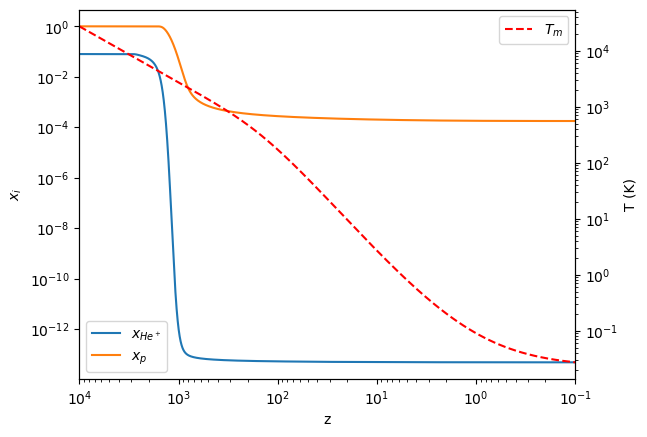

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/james/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(623.793035413954, 0.5, 'T (K)')

In [10]:
loglog(sol.t, [s[1] for s in sol.u], label = L"x_{He^+}")
loglog(sol.t, [s[2] for s in sol.u], label = L"x_p")
xlim(1e4, .1)
xlabel("z")
ylabel(L"x_i")
legend(loc = "lower left")
twinx()
loglog(sol.t, [s[3] for s in sol.u], label = L"T_m", "r--")
legend()
ylabel("T (K)")

The standard Recfast++ variation of fundamental constants functionality can be used for unintended purposes to study atomic dark matter. However, in order to preserve the vanilla Recfast++ functionality this does have a few quirks. Specifically, we need to set 
\begin{equation}
N_{\rm eff} \rightarrow \frac{1}{\xi^4}
\left[N_{\rm eff} + \frac{8}{7}\left(\frac{T_{\rm cmb}}{T_\nu}\right)^{4}\right] = \frac{7.449}{\xi^4}
\end{equation}

to account for the contribution to the expansion from the Standard Model radiation, and 
\begin{equation}
\Omega_B = \Omega_{DM}/r_M,
\end{equation}
since the "baryons" are the dark matter. 

Let's make a new "parameters" struct for dark matter with $xi =0.01$, $r_M = 14$, $r_\alpha = 1.37$, and $r_m=0.1$. 

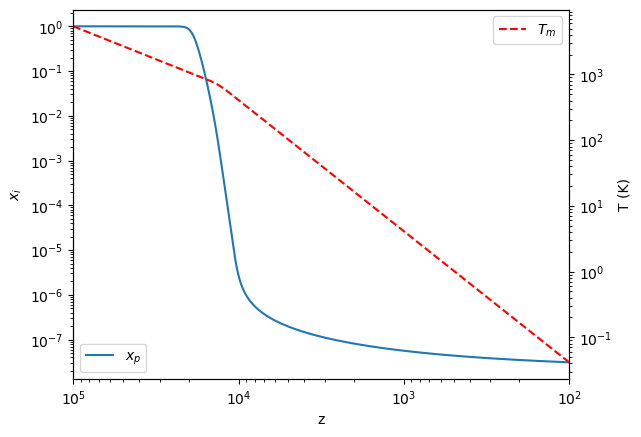

PyObject Text(617.6700587293836, 0.5, 'T (K)')

In [11]:
p = Params(Yp = 0.0, T0=2.7 * .02, n_eff= 7.449/.02^4, Omega_B = (.26-.044)/14)
Set_VFC_params!(p, mS= 0.1, mxS = 14, aS = 1.37)
#it is sometimes necessary to adjust the initial and minimum step size. 
sol = Evaluate_recombination(p, logzstart = 5, logzend = 2., dt = 1e-10, dtmin = 1e-13, dtmax = 0.01)
loglog(sol.t, [s[2] for s in sol.u], label = L"x_p")
xlim(1e5, 1e2)
xlabel("z")
ylabel(L"x_i")
legend(loc = "lower left")
twinx()
loglog(sol.t, [s[3] for s in sol.u], label = L"T_m", "r--")
legend()
ylabel("T (K)")

We have added in a minimal reaction network to accomodate the formation of molecules. Here's how to use it. 

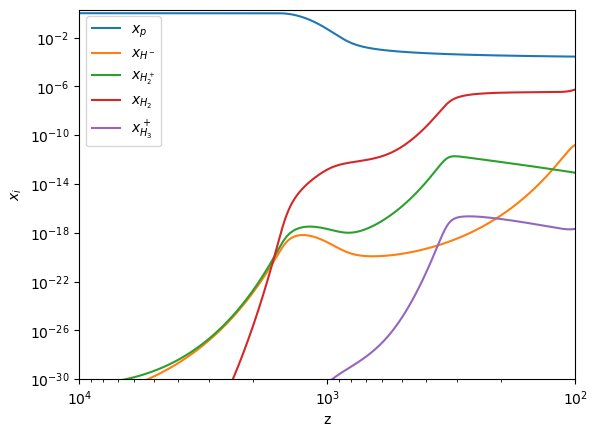

PyObject <matplotlib.legend.Legend object at 0x7f6e32736e90>

In [12]:
p = Params()
sol = Evaluate_recombination_h2(p, logzstart = 4., logzend = 1., dt = 1e-10, dtmin = 1e-30, dtmax= 0.01)
loglog(sol.t, [s[2] for s in sol.u], label = L"x_p")
loglog(sol.t, [s[4] for s in sol.u], label = L"x_{H^-}")
loglog(sol.t, [s[5] for s in sol.u], label = L"x_{H_2^+}")
loglog(sol.t, [s[6] for s in sol.u], label = L"x_{H_2}")
loglog(sol.t, [s[7] for s in sol.u], label = L"x_{H_3}^+")

xlim(1e4, 1e2)
ylim(1e-30, 2)
xlabel("z")
ylabel(L"x_i")
legend()

We can multiply each rate by an arbitrary factor, indexed by an 16 element array as follows. For explanation of the numbering, see Table 1 of https://arxiv.org/abs/2110.11964. 

1. Recombination and photoionization
2. CH3
3. CH4
4. CH5
5. CH7
6. CH8
7. CH9
8. CH10
9. CH13
10. CH15
11. CH20
12. CH*
13. 3B1
14. 3B2
15. 3B3
16. 3B4

Let's turn off the $H^-$ production. 

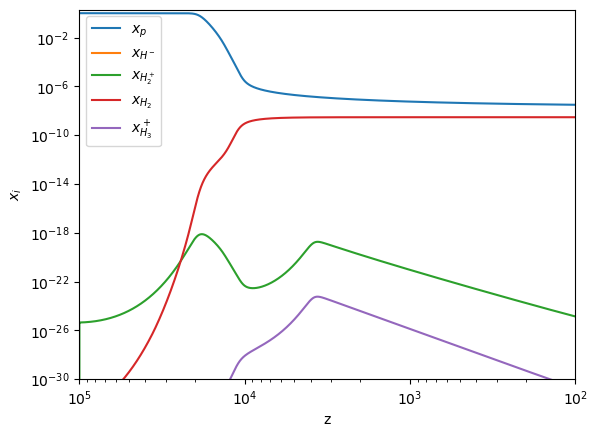

PyObject <matplotlib.legend.Legend object at 0x7f6e3243f650>

In [14]:
p = Params(Yp = 0.0, T0=2.7 * .02, n_eff= 7.449/.02^4, Omega_B = (.26-.044)/14)
Set_VFC_params!(p, mS= 0.1, mxS = 14, aS = 1.37)
artificials = ones(16)
artificials[2] =0.
Set_artificial_rates!(p, artificials)
sol = Evaluate_recombination_h2(p, logzstart = 5., logzend = 2., dtmax= 1e-3) #we need to limit the max step size
# to keep the very low H_3^+ fraction smooth
loglog(sol.t, [s[2] for s in sol.u], label = L"x_p")
loglog(sol.t, [s[4] for s in sol.u], label = L"x_{H^-}")
loglog(sol.t, [s[5] for s in sol.u], label = L"x_{H_2^+}")
loglog(sol.t, [s[6] for s in sol.u], label = L"x_{H_2}")
loglog(sol.t, [s[7] for s in sol.u], label = L"x_{H_3}^+")

xlim(1e5, 1e2)
ylim(1e-30, 2)
xlabel("z")
ylabel(L"x_i")
legend()